### Lib import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn import metrics
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

from scipy.special import expi
from scipy.stats import pearsonr
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')
cmap = plt.cm.inferno

### Declare Function

In [2]:
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap_temp = plt.cm.inferno
    xplot_step = (x_max-x_min)/100; yplot_step = (y_max-y_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step),
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap_temp,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap_temp, norm=None, vmin=z_min, vmax=z_max, alpha=1.0, linewidths=0.8, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    
def data_load_processing(file_name, sheet_name):
    data = pd.read_excel(file_name, sheet_name=sheet_name)
    data = data.iloc[:,[1,2]]
    data = data.drop(index=[0,1])
    data = data.reset_index()
    data = data.drop(columns=['index'])
    data.columns = ['Time', 'Pressure']
    data = data.dropna()
    
    return data

### Parameters set up

In [3]:
#Dimentions
# q = bbl/d; P = psi; m = cp; k = mD; h = ft; phi = %; ct = psi^(-1); t = hours

#Parameters
q1 = 20000           #bbl/d
q2 = 400           #bbl/d  -  second well
P = 4350           #psi
m = 0.89           #cp 
k = 100            #mD 
ct = 6*10**(-6)      #1/psi
r = 0.178*3.28084    # meter to ft (7 inch radius)
h = 100             #ft
s = -3
phi = 0.25
gamma = 1.781

### Data import

In [4]:
transient1 = data_load_processing('Fall_offs.xlsx', 'Transient 1')
transient2 = data_load_processing('Fall_offs.xlsx', 'Transient 2')
transient3 = data_load_processing('Fall_offs.xlsx', 'Transient 3')
transient4 = data_load_processing('Fall_offs.xlsx', 'Transient 4')
transient5 = data_load_processing('Fall_offs.xlsx', 'Transient 5')

In [5]:
transient1

,Time,Pressure
0,0.004167,65.47
1,0.008333,136.37
2,0.0125,140.8
3,0.016667,140.8
4,0.020833,144.94
...,...,...
195,45.308351,1091.88
196,46.604184,1099.98
197,47.925017,1108.09
198,49.295851,1116.14


## Curve fit

In [6]:
#Curve fitting after wellbore storage effect
df1 = transient1[transient1['Time']>3]
df2 = transient2[transient2['Time']>3]
df3 = transient3[transient3['Time']>3]
df4 = transient4[transient4['Time']>3]
df5 = transient5[transient5['Time']>3]

data = [df1,df2,df3,df4,df5]
for df in data:
    df.reset_index(drop=True, inplace=True)

In [7]:
#mobility = k*h/m (mD*ft/cp)

mobility = []
rel_mobility = []
b = []
for df in data:
    coef = np.polyfit(np.log10((df['Time']).astype(float)),(df['Pressure']).astype(float),1)
    mob = 162.6*q1/coef[0]
    b.append(coef[1])
    mobility.append(mob)
for i in range(len(mobility)):
    rel_mobility.append(mobility[i]/mobility[0])

#adding fitted curve 
for df in enumerate(data):
    df[1]['Log_approx'] = 162.6*q1/mobility[df[0]]*np.log10((df[1]['Time']).astype(float)) + b[df[0]]

#transient1['Log_approx'] = 300.89*np.log10((transient1['Time']).astype(float))+ 397.75
mobility

[5679.764427637121,
 4651.666157579144,
 4346.810402980299,
 3435.4003579049936,
 3284.519947822725]

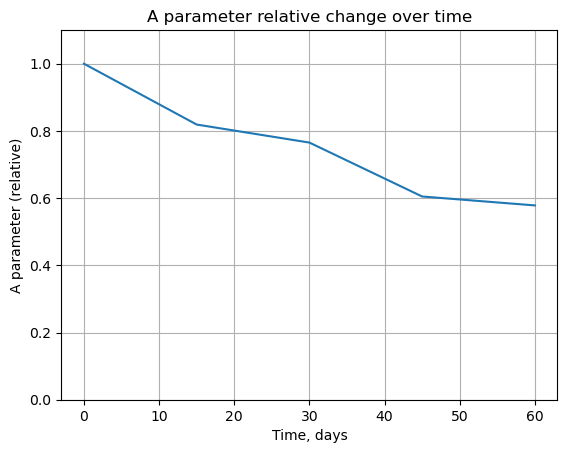

In [8]:
#dt between pressure responces = 12 days
time = np.linspace(0,12*5,5)
plt.plot(time,rel_mobility)
plt.title('A parameter relative change over time'); plt.xlabel('Time, days'); plt.ylabel('A parameter (relative)') 
plt.ylim(0,1.1); plt.grid()

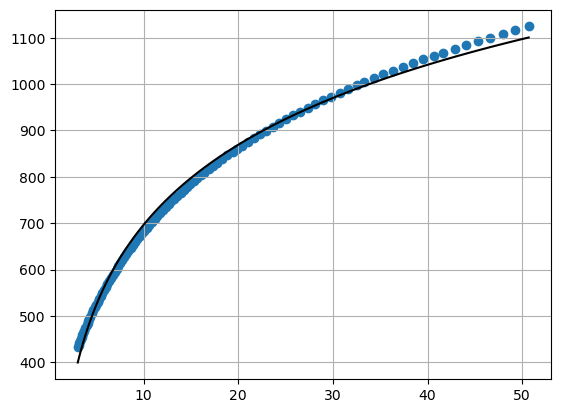

In [82]:
plt.style.use('default')
plt.scatter(df1.Time,df1.Pressure)
plt.plot(df1.Time, df1.Log_approx, c='k')
#plt.xscale('log')
plt.grid()

In [83]:
mobility

[5679.764427637121,
 4651.666157579144,
 4346.810402980299,
 3435.4003579049936,
 3284.519947822725]

## First approach - pattern as a time serie

## Second approach - regression analysis

### Train test data split. Scaling

In [84]:
# data aggregation
transient_data = [transient1, transient2, transient3, transient4, transient5]
for df in enumerate(transient_data):
    df[1]['Mobility'] = mobility[df[0]]
    df[1]['Flow'] = 0
    for i in range(len(df[1])):
        if df[1]['Time'][i] > 3:
            df[1].loc[i,['Flow']] = 1
        else:
            df[1].loc[i,['Flow']] = 0 

dataset = pd.DataFrame()
dataset = pd.concat(transient_data)

In [85]:
# Wellbore storage and radial flow are balanced quite equally
dataset.Flow.value_counts()

1    562
0    527
Name: Flow, dtype: int64

In [86]:
dataset.head()

,Time,Pressure,Mobility,Flow
0,0.004167,65.47,5679.764428,0
1,0.008333,136.37,5679.764428,0
2,0.0125,140.8,5679.764428,0
3,0.016667,140.8,5679.764428,0
4,0.020833,144.94,5679.764428,0


In [108]:
# Train test data split
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:,[0,1,3]], dataset.iloc[:,2],
                                                    test_size=0.20, random_state=73073)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train = pd.DataFrame(y_train.values, columns=['Mobility'])
y_test = pd.DataFrame(y_test.values, columns=['Mobility'])

# Scaler declare
scaler = MinMaxScaler()
scaler_y = MinMaxScaler()
# Fit
scaler.fit_transform(dataset.iloc[:,[0,1,3]])
scaler_y.fit_transform(dataset.iloc[:,2].values.reshape(-1,1))
# Scale
X_train_s = scaler.transform(X_train); X_test_s = scaler.transform(X_test)
y_train_s = scaler_y.transform(y_train); y_test_s = scaler_y.transform(y_test)

### Random Forest regression

In [109]:
# Perform random forest regression

rf = RandomForestRegressor()   # instantiate the random forest  
rf = rf.fit(X_train, y_train) # fit the random forest

prediction = rf.predict(X_test)
MSE = mean_squared_error(y_test['Mobility'], prediction)
Var_Exp = explained_variance_score(y_test['Mobility'], prediction)
R2 = r2_score(y_test['Mobility'], prediction)
corr = math.sqrt(R2)
error = prediction-y_test['Mobility']
mean = np.mean(error)
std = np.std(error)

Error standard deviation is 392.76 mD*ft/cp
Mean squared error is 154262.69
Coefficiant of determination is 0.796
Correlation coefficient is 0.892
Variance explained score is 0.796


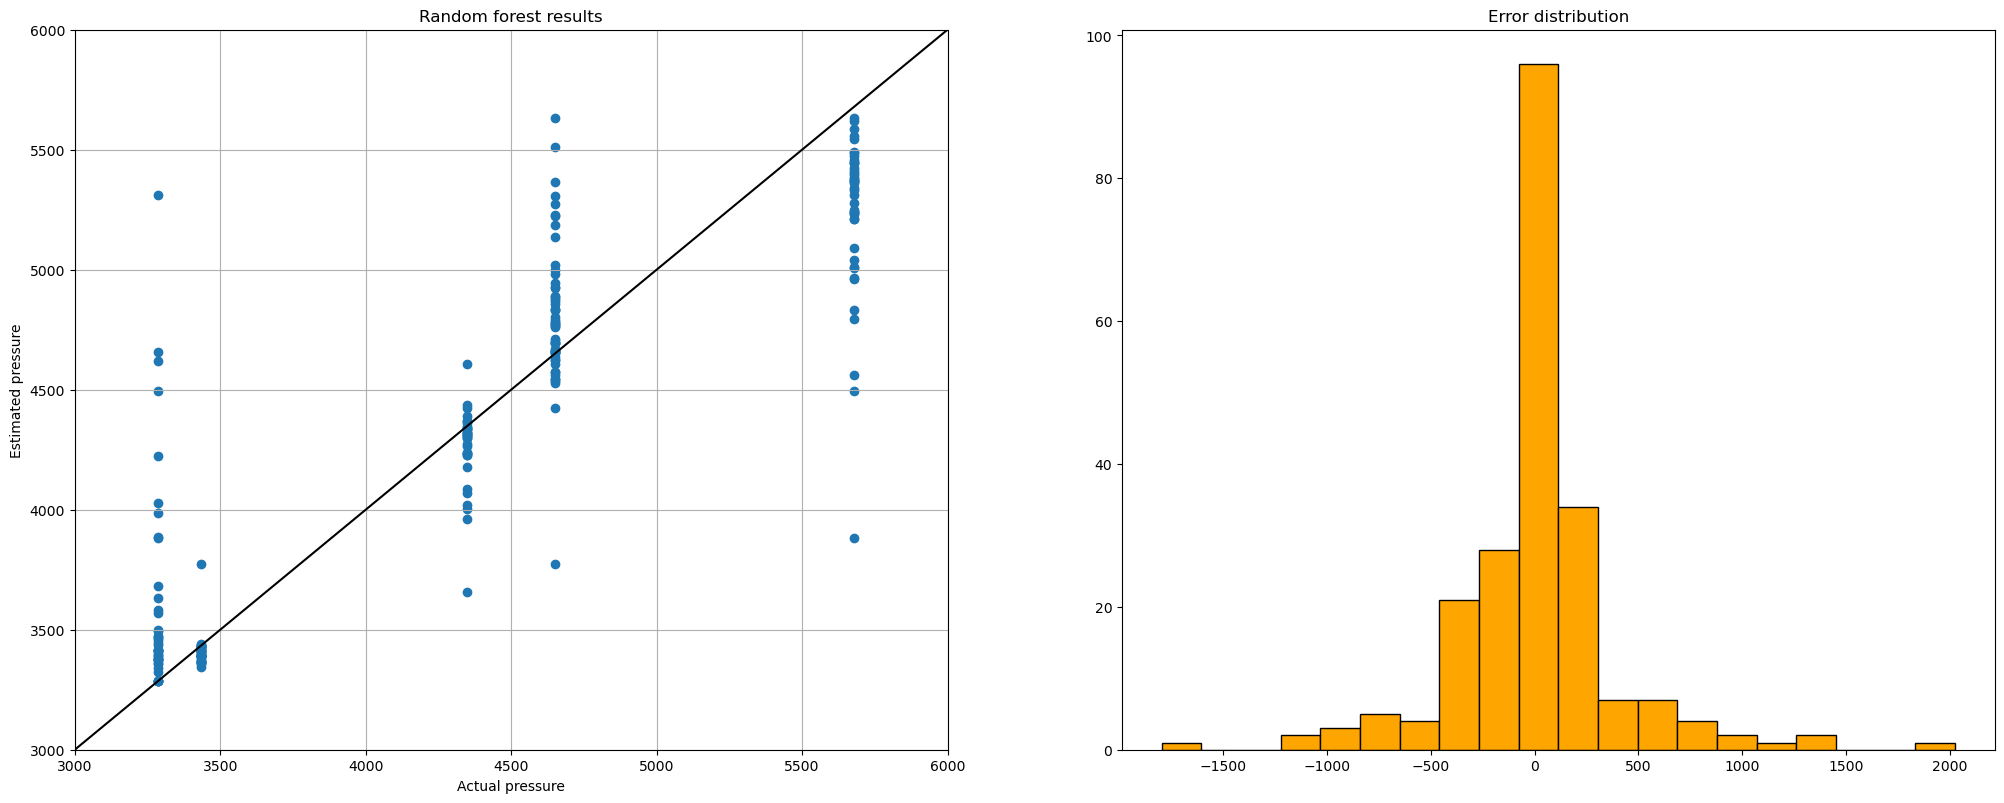

In [110]:
print('Error standard deviation is ' + str("{:.2f}".format(std)) + ' mD*ft/cp')
print('Mean squared error is ' + str("{:.2f}".format(MSE)))
print('Coefficiant of determination is ' + str("{:.3f}".format(R2)))
print('Correlation coefficient is ' + str("{:.3f}".format(corr)))
print('Variance explained score is ' + str("{:.3f}".format(Var_Exp)))

plt.subplot(1,2,1)
plt.scatter(y_test, prediction)
plt.plot([3000,6000],[3000,6000], c='k'); plt.xlim(3000,6000); plt.ylim(3000,6000)
plt.title('Random forest results'); plt.xlabel('Actual pressure'); plt.ylabel('Estimated pressure')
plt.grid()

plt.subplot(1,2,2)
plt.hist(error, color='orange', edgecolor='black', bins=20)
plt.title('Error distribution')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

### K-Nearest Neighbors

In [125]:
# Hyperparameters tuning
k = 1
dist_error = []
unif_error = []
k_mat = []
while k <= 150:
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 1)
    neigh_dist_fit = neigh_dist.fit(X_train_s,y_train_s)  
    y_pred_s = neigh_dist_fit.predict(X_test_s)
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1,1))
    MSE = metrics.mean_squared_error(y_test,y_pred)
    dist_error.append(MSE)
    
    neigh_unif = KNeighborsRegressor(weights = 'uniform', n_neighbors=k, p = 1)
    neigh_unif_fit = neigh_unif.fit(X_train_s,y_train_s)  
    y_pred_s = neigh_unif_fit.predict(X_test_s)
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1,1))
    MSE = metrics.mean_squared_error(y_test,y_pred)
    unif_error.append(MSE)
    k_mat.append(k)
    k = k + 1

Minimum error using arithmetic average is 159941.40 when k = 4
Minimum error using inverse distance weighting is 136400.90 when k = 8


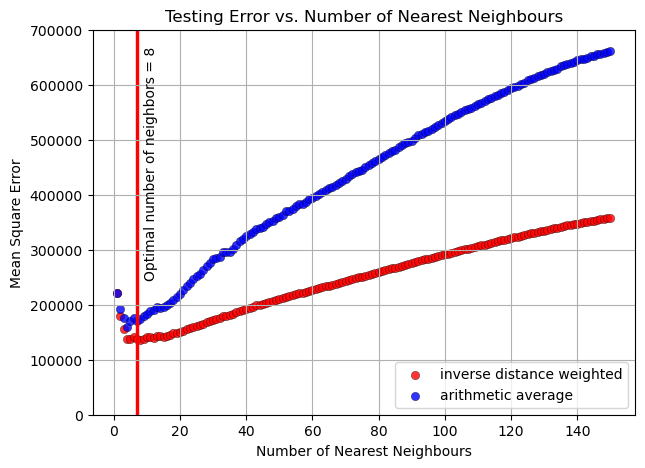

In [126]:
# Find optimal number of neighbors
print('Minimum error using arithmetic average is ' + str("{:0.2f}".format(min(unif_error))) + ' when k = ' + 
     str(unif_error.index(min(unif_error))+1))
print('Minimum error using inverse distance weighting is ' + str("{:0.2f}".format(min(dist_error))) + ' when k = ' + 
     str(dist_error.index(min(dist_error))+1))


# Plot the hyperparameter tuning process
plt.figure(figsize=(7,5))
plt.scatter(k_mat,dist_error,s=None, c='red',label = 'inverse distance weighted',
            marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.scatter(k_mat,unif_error,s=None, c='blue',label = 'arithmetic average',
            marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.arrow(np.argmin(dist_error),0,0,700000,width=0.5,color='red',head_length=0.0,head_width=0.0)
plt.annotate('Optimal number of neighbors = ' + str("{:0.0f}".format(np.argmin(dist_error)+1)),
             (np.argmin(dist_error)+2,2.5e5),rotation=90)
plt.title('Testing Error vs. Number of Nearest Neighbours');
plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
plt.ylim(0,7.0e5)
plt.legend(); plt.grid()
#plt.xlim(0,50); plt.ylim(0,800000)
plt.show()

In [127]:
# K-Nearest Neighbors model
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=8, p = 1)
neigh_fit = neigh.fit(X_train_s,y_train_s)

prediction_s = neigh_fit.predict(X_test_s)
prediction = scaler_y.inverse_transform(prediction_s.reshape(-1,1))
MSE_K = mean_squared_error(y_test['Mobility'], prediction)
Var_Exp_K = explained_variance_score(y_test['Mobility'], prediction)
R2_K = r2_score(y_test['Mobility'], prediction)
corr_K = math.sqrt(R2_K)
error_K = prediction.ravel()-y_test['Mobility'].values
mean_K = np.mean(error_K)
std_K = np.std(error_K)

Error standard deviation is 369.26 mD*ft/cp
Mean squared error is 136400.90
Coefficiant of determination is 0.820
Correlation coefficient is 0.906
Variance explained score is 0.820


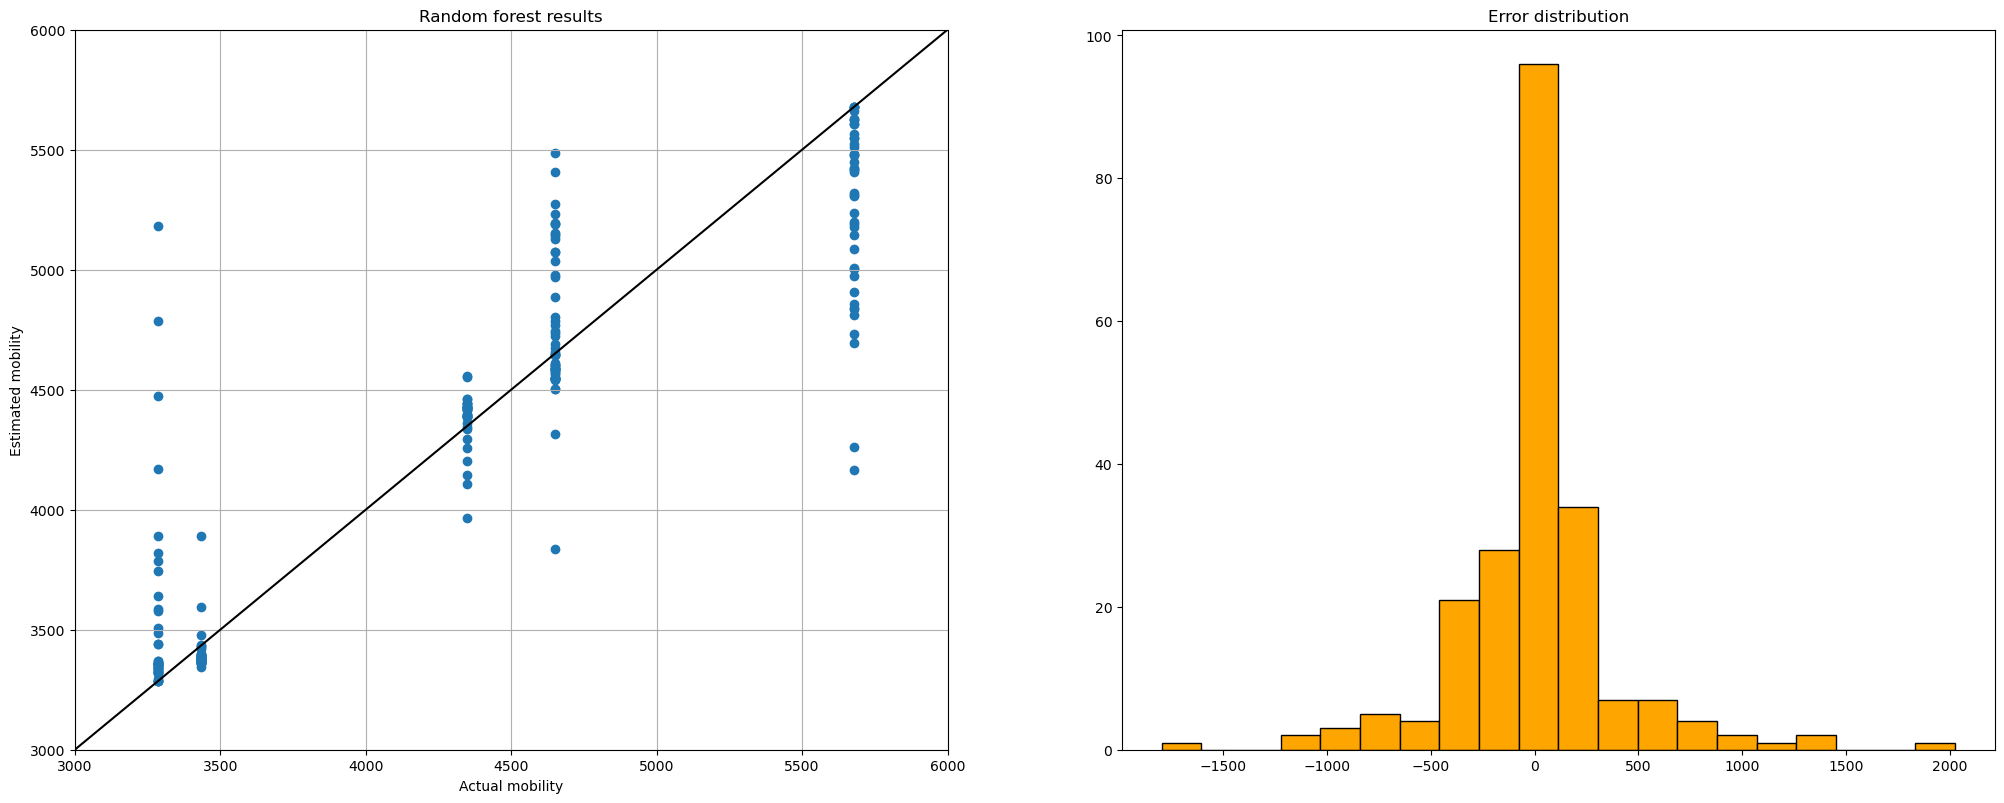

In [128]:
print('Error standard deviation is ' + str("{:.2f}".format(std_K) + ' mD*ft/cp'))
print('Mean squared error is ' + str("{:.2f}".format(MSE_K)))
print('Coefficiant of determination is ' + str("{:.3f}".format(R2_K)))
print('Correlation coefficient is ' + str("{:.3f}".format(corr_K)))
print('Variance explained score is ' + str("{:.3f}".format(Var_Exp_K)))

plt.subplot(1,2,1)
plt.scatter(y_test, prediction)
plt.plot([3000,6000],[3000,6000], c='k'); plt.xlim(3000,6000); plt.ylim(3000,6000)
plt.title('Random forest results'); plt.xlabel('Actual mobility'); plt.ylabel('Estimated mobility')
plt.grid()

plt.subplot(1,2,2)
plt.hist(error, color='orange', edgecolor='black', bins=20)
plt.title('Error distribution')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

### K-Nearest Neighbors model with P&t only (pattern visualization)

In [144]:
# Train test data split
X_train_second, X_test_second, y_train_second, y_test_second = train_test_split(dataset.iloc[:,[0,1]],
                                                                dataset.iloc[:,2],test_size=0.20, random_state=73073)

X_train_second.reset_index(drop=True, inplace=True)
X_test_second.reset_index(drop=True, inplace=True)
y_train_second = pd.DataFrame(y_train_second.values, columns=['Mobility'])
y_test_second = pd.DataFrame(y_test_second.values, columns=['Mobility'])

# Scaler declare
scaler_second = MinMaxScaler()
scaler_second_y = MinMaxScaler()
#Fit
scaler_second.fit_transform(dataset.iloc[:,[0,1]])
scaler_second_y.fit_transform(dataset.iloc[:,2].values.reshape(-1,1))
#Scale
X_train_second_s = scaler_second.transform(X_train_second);
X_test_second_s = scaler_second.transform(X_test_second)
X_train_second_s = pd.DataFrame(X_train_second_s, columns = X_train_second.columns)
X_test_second_s = pd.DataFrame(X_test_second_s, columns = X_test_second.columns)
y_train_second_s = scaler_second_y.transform(y_train_second);

In [145]:
# K-Nearest Neighbors second model
neigh = KNeighborsRegressor(weights = 'distance', n_neighbors=8, p = 1)
neigh_fit_second = neigh.fit(X_train_second_s,y_train_second_s)

prediction_second_s = neigh_fit_second.predict(X_test_second_s)
prediction_second = scaler_second_y.inverse_transform(prediction_second_s.reshape(-1,1))
MSE_K = mean_squared_error(y_test_second, prediction_second)
Var_Exp_K = explained_variance_score(y_test_second, prediction_second)
R2_K = r2_score(y_test_second, prediction_second)
corr_K = math.sqrt(R2_K)
error_K = prediction_second.ravel()-y_test_second.values
mean_K = np.mean(error_K)
std_K = np.std(error_K)

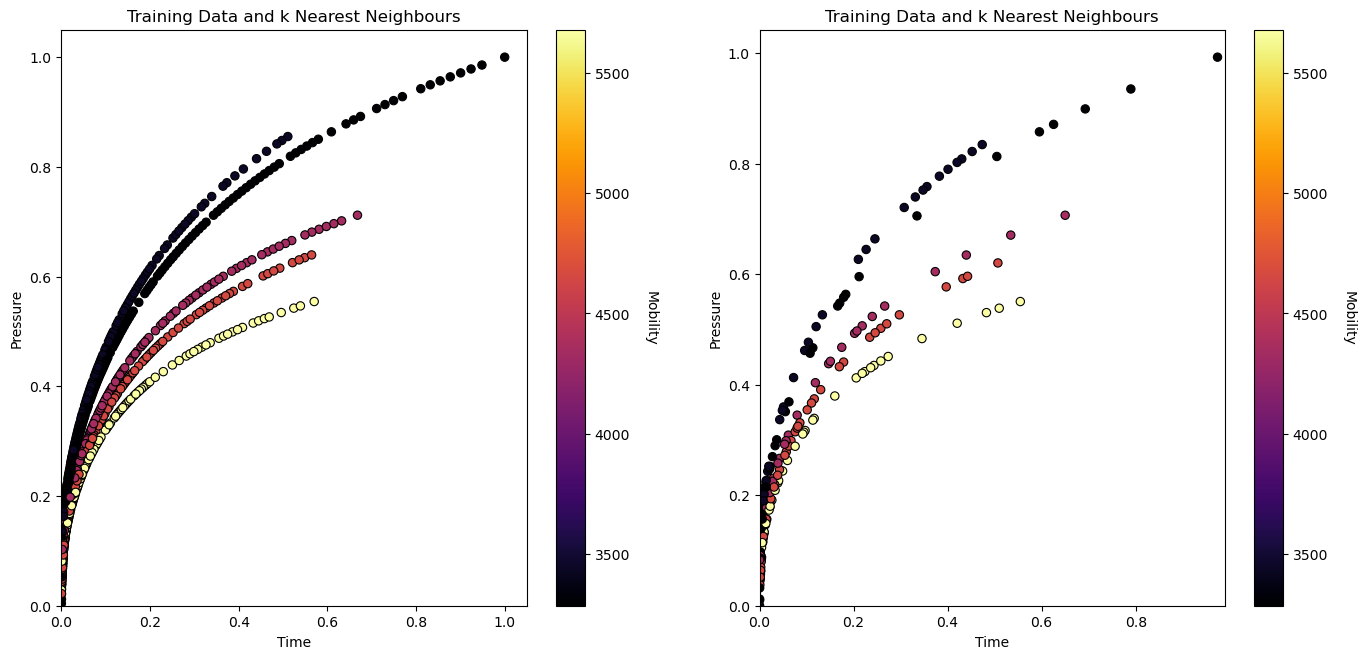

In [152]:
# Plot results
plt.subplot(121)
visualize_model(neigh_fit_second,X_train_second_s['Time'],0,1,X_train_second_s['Pressure'],0,1,
                y_train_second['Mobility'],min(dataset['Mobility']),max(dataset['Mobility']),
                'Training Data and k Nearest Neighbours')

plt.subplot(122)
visualize_model(neigh_fit_second,X_test_second_s['Time'],0,1,X_test_second_s['Pressure'],0,1,
                y_test_second['Mobility'],min(dataset['Mobility']),max(dataset['Mobility']),
                'Training Data and k Nearest Neighbours')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

### Gradient boosting decision trees